In [116]:
import spacy
from sklearn.datasets import fetch_20newsgroups
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
nltk.download('punkt')
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import time
from nltk import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
print('Success')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Success


In [0]:
twenty_train=fetch_20newsgroups(subset='train', shuffle=True, download_if_missing=True)
twenty_test=fetch_20newsgroups(subset='test', shuffle=True, download_if_missing=True)

In [118]:
twenty_train.data[0]
type(twenty_train)
text = [word for word in twenty_train.data]
text
print('Done')

Done


In [119]:
text[7725]

'From: jnielsen@magnus.acs.ohio-state.edu (John F Nielsen)\nSubject: Re: Integra GSR\nArticle-I.D.: magnus.1993Apr6.143853.11641\nOrganization: The Ohio State University\nLines: 17\nNntp-Posting-Host: photon.magnus.acs.ohio-state.edu\n\nIn article <1993Apr6.035020.16730@cactus.org> boyle@cactus.org (Craig Boyle) writes:\n>miles, a rare screw up by Honda.\n>Both the GTZ and GSR are flawed cars. The performance enthusiasts would take\n>the GTZ and the CR purchase would be the GSR.\n>\n\n\nThe CR purchase would be the Ford Probe GT.\n\njohn\n\n\n-- \nJohn Nielsen   MAGNUS Consultant            ______   ______   __  __\t\n"To you Baldrick, the Renaissance was just /\\  __ \\ /\\  ___\\ /\\ \\/\\ \\\nsomething that happened to other people,   \\ \\ \\/\\ \\\\ \\___  \\\\ \\ \\_\\ \\\nwasn\'t it?" - The Black Adder               \\ \\_____\\\\/\\_____\\\\ \\_____\\\n'

In [120]:
len(text)

11314

In [0]:
doc=['doc'+str(i) for i in range(0,len(text))]

In [122]:
df=pd.DataFrame(data=doc,index=None, columns=['doc_no'])
df['data']=text
df.head()

,doc_no,data
0,doc0,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,doc1,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,doc2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,doc3,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,doc4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...


In [0]:
df['data'].dropna(inplace=True)
#doc['Content.'] = doc['Content.'].astype("|S")
df = df[df['data'].map(type)==str]

In [124]:
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head(5)

,doc_no,data
0,doc930,From: rachford@en.ecn.purdue.edu (Jeffery M Ra...
1,doc5646,From: janet@ntmtv.com (Janet Jakstys)\nSubject...
2,doc9692,From: she3328@ritvax.isc.rit.edu (Steven H. Ec...
3,doc8103,From: pgf@srl02.cacs.usl.edu (Phil G. Fraering...
4,doc5488,From: dchamber@b15news.b15.ingr.com (Doug Cham...


In [155]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", text)
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", " ", text)
    text = re.sub(r'\d+',' ', text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['one', 'dont', 'get', 'edu', 'use','subject','line','article','would','nntp','ssip','organisation'])
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text
    
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
  text=[lemmatizer.lemmatize(word) for word in text if len(word)>2]
  return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return word_lemmatizer(stem_words(remove_stop_words(initial_clean(text)))) #stemming removed currently

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [156]:
# clean text and title and create new column "tokenized"
t1 = time.time()
df['tokenized'] = df['data'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 9218 articles: 1.1337515552838644 min


In [157]:
df['tokenized']

0       [exercis, migrain, post, host, pegasu, organ, ...
1       [dream, degre, organ, univ, southwestern, loui...
2       [cheroke, explor, organ, intergraph, corpor, h...
3       [visit, jehovah, wit, distribut, world, local,...
4       [gui, applic, framework, window, organ, cimlin...
                              ...                        
9213    [ide, scsi, organ, john, robart, research, ins...
9214    [scienc, methodolog, organ, univers, rochest, ...
9215    [need, advic, select, sound, card, keyword, so...
9216    [command, loss, timer, organ, express, access,...
9217    [legal, jewish, purchas, organ, aiken, comput,...
Name: tokenized, Length: 9218, dtype: object

In [158]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

52959

In [159]:
k = 8000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('osc', 15),
 ('ahh', 15),
 ('aegean', 15),
 ('copt', 15),
 ('clv', 15),
 ('ttt', 15),
 ('gyro', 15),
 ('settler', 15),
 ('evz', 15),
 ('hga', 15)]

In [0]:
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [161]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)
df['tokenized']

0       [exercis, migrain, post, host, pegasu, organ, ...
1       [dream, degre, organ, univ, southwestern, loui...
2       [explor, organ, intergraph, corpor, huntsvil, ...
3       [visit, jehovah, wit, distribut, world, local,...
4       [gui, applic, framework, window, organ, inc, e...
                              ...                        
9213    [ide, scsi, organ, john, research, institut, l...
9214    [scienc, methodolog, organ, univers, rochest, ...
9215    [need, advic, select, sound, card, keyword, so...
9216    [command, loss, timer, organ, express, access,...
9217    [legal, jewish, purchas, organ, aiken, comput,...
Name: tokenized, Length: 9218, dtype: object

In [162]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 9218 
average document length 144.3090692124105 
minimum document length 36 
maximum document length 5610


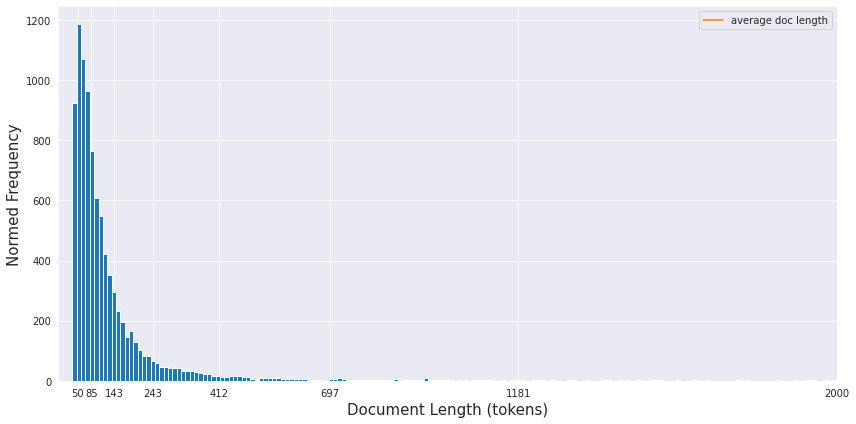

In [163]:
# plot a histogram of document length
num_bins = 500
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,2000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [164]:
# only keep articles with more than 30 tokens, otherwise too short
df = df[df['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 9207 articles


In [0]:
# create a mask of binary values
msk = np.random.rand(len(df)) < 0.999

In [0]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [167]:
print(len(df),len(train_df),len(test_df))

9207 9197 10


In [0]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 10
    chunksize = 300
    dictionary = corpora.Dictionary(df['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in df['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [169]:
dictionary,corpus,lda = train_lda(train_df)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Time to train LDA model on  9207 articles:  0.30011463165283203 min


In [170]:
lda.show_topics()

[(0,
  '0.013*"god" + 0.009*"christian" + 0.008*"say" + 0.008*"believ" + 0.008*"write" + 0.007*"think" + 0.007*"peopl" + 0.006*"line" + 0.006*"organ" + 0.006*"jesu"'),
 (1,
  '0.025*"space" + 0.011*"launch" + 0.010*"nasa" + 0.008*"orbit" + 0.008*"satellit" + 0.007*"post" + 0.007*"project" + 0.007*"organ" + 0.006*"research" + 0.006*"center"'),
 (2,
  '0.011*"write" + 0.011*"like" + 0.011*"peopl" + 0.010*"think" + 0.009*"know" + 0.008*"time" + 0.008*"line" + 0.008*"say" + 0.008*"organ" + 0.007*"thing"'),
 (3,
  '0.018*"key" + 0.015*"system" + 0.013*"use" + 0.013*"chip" + 0.012*"encrypt" + 0.009*"line" + 0.008*"organ" + 0.008*"clipper" + 0.008*"need" + 0.007*"work"'),
 (4,
  '0.016*"jew" + 0.014*"israel" + 0.014*"isra" + 0.010*"kill" + 0.010*"arab" + 0.009*"jewish" + 0.009*"war" + 0.007*"write" + 0.007*"human" + 0.007*"peopl"'),
 (5,
  '0.018*"window" + 0.014*"file" + 0.012*"program" + 0.011*"use" + 0.008*"system" + 0.007*"version" + 0.007*"run" + 0.007*"includ" + 0.006*"line" + 0.006*"av

In [0]:
doc_freq=[]
for i in range(0,len(train_df)):
  bow = dictionary.doc2bow(train_df.iloc[i,2])
  doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])
  doc_freq.append(doc_distribution)
doc_freq
freq_max=np.argmax(doc_freq, axis=1)

In [172]:
freq_max[0:20]

array([2, 2, 6, 0, 5, 6, 5, 2, 6, 2, 0, 5, 8, 5, 9, 7, 6, 3, 6, 6])

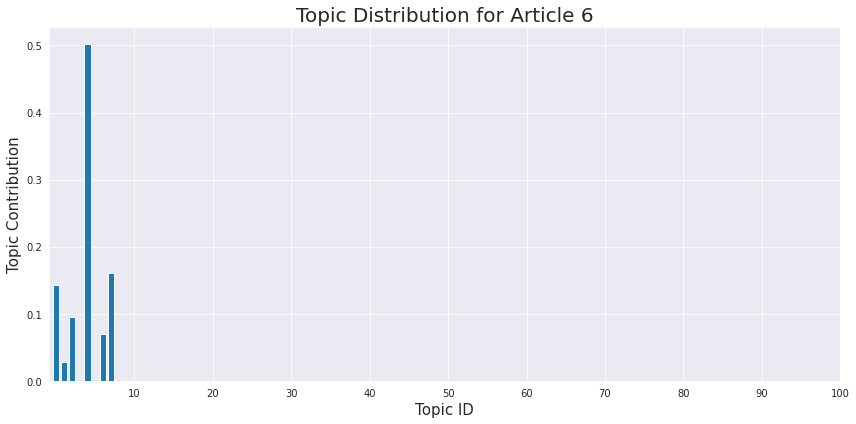

In [173]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(6), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [174]:
for i in doc_distribution.argsort()[0:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=20), "\n")

4 [('jew', 0.015766958), ('israel', 0.014495087), ('isra', 0.013888781), ('kill', 0.0103519745), ('arab', 0.009658021), ('jewish', 0.008566278), ('war', 0.008560291), ('write', 0.0069750706), ('human', 0.0067389323), ('peopl', 0.006685687), ('organ', 0.0066064596), ('child', 0.006395639), ('line', 0.006354903), ('attack', 0.0063388133), ('state', 0.0062968885), ('men', 0.0061391774), ('homosexu', 0.005742081), ('death', 0.005558511), ('right', 0.0054021156), ('univers', 0.005339091)] 

7 [('govern', 0.012488053), ('gun', 0.011692863), ('law', 0.011677143), ('state', 0.010381638), ('peopl', 0.009582362), ('right', 0.009505721), ('presid', 0.007125011), ('armenian', 0.0065824417), ('public', 0.005462786), ('american', 0.005199215), ('firearm', 0.0051527796), ('weapon', 0.005106915), ('nation', 0.0048427605), ('clinton', 0.0048117116), ('countri', 0.004584478), ('crime', 0.004540948), ('issu', 0.0044372664), ('bill', 0.0042113815), ('polit', 0.004194276), ('year', 0.004124723)] 

0 [('god

In [175]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=7, angle=.99, init='pca')# 13-D -> 2-D
tsne_lda = tsne_model.fit_transform(doc_freq) # doc_topic is document-topic matrix from LDA or GuidedLDA 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9197 samples in 0.012s...
[t-SNE] Computed neighbors for 9197 samples in 0.789s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9197
[t-SNE] Computed conditional probabilities for sample 2000 / 9197
[t-SNE] Computed conditional probabilities for sample 3000 / 9197
[t-SNE] Computed conditional probabilities for sample 4000 / 9197
[t-SNE] Computed conditional probabilities for sample 5000 / 9197
[t-SNE] Computed conditional probabilities for sample 6000 / 9197
[t-SNE] Computed conditional probabilities for sample 7000 / 9197
[t-SNE] Computed conditional probabilities for sample 8000 / 9197
[t-SNE] Computed conditional probabilities for sample 9000 / 9197
[t-SNE] Computed conditional probabilities for sample 9197 / 9197
[t-SNE] Mean sigma: 0.069181
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.589462
[t-SNE] KL divergence after 1000 iterations: 1.566040


In [190]:
topic_num = np.argmax(doc_freq,axis=1)
#for i in range(0,len(topic_num)):
#  if topic_num[i]>=10:
#    topic_num[i]=9
tp=pd.Series(topic_num)
tp.unique()

array([2, 6, 0, 5, 8, 9, 7, 3, 4, 1])

In [196]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num],)
show(plot)

In [0]:
imUsingColab = False

if imUsingColab:
    !pip install gensim
    !pip install pyLDAvis
    !pip install vega
    !pip install altair

In [193]:
 !pip install pyLDAvis

In [0]:
import gensim
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [0]:
p=pyLDAvis.gensim.prepare(lda, corpus, dictionary)

In [0]:
pyLDAvis.save_html(p, 'lda_dyn.html')